# Capital Bikeshare User Demand Prediction

#### Jinxin Ma 09.26.2017

This Jupyter notebook presents an end-to-end machine learning project. The goal is to predict user demand of bikes. The structure of the notebook is as follows:

1. Exploratory Data Analysis

        1.1 Read and Split Data
        1.2 Missing Value Exploration
        1.3 Summary Statistics and Outlier Detection
        1.4 Correlation Analysis
2. Feature Engineering and Modeling

        2.1 Data Preprocessing
        2.2 Baseline Models
        2.3 Feature Engineering
        2.4 Improved Models
        2.5 Feature Importance Analysis
        2.6 Final Models and Predictions

3. Summary

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.preprocessing import Imputer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.externals import joblib

# pipeline and user-defined class
from sklearn.base import BaseEstimator, TransformerMixin

# display plots in notebook
%matplotlib inline
sns.set(style="whitegrid", color_codes=True)

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 10),
         'axes.labelsize': 18,
         'axes.titlesize': 16,
         'xtick.labelsize': 16,
         'ytick.labelsize': 16}
plt.rcParams.update(params)

/Users/jinxin/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 1. Exploratory Data Analysis

### 1.1 Read and Split Data

In [2]:
data = pd.read_csv('hourly_users_data.csv')

# "dteday" is like timestamp, can drop it for now
data = data.drop(['dteday'], axis=1)

We want to make sure the distribution of the test data is the same to the training data. StratifiedShuffleSplit in Scikit learn can help us achieve that. Here I choose to split based on "mnth".

In [3]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42) 

for train_index, test_index in split.split(data, data['mnth']): 
    X_train = data.loc[train_index] 
    X_test = data.loc[test_index]

# we have both categorical and numerical features
cat_features = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']
num_features = ['temp', 'atemp', 'hum', 'congeniality', 'windspeed', 'wobbliness']
response = ['cnt', 'casual', 'registered']

### 1.2 Missing Data Exploration

Let's first check if there are missing values in the data set. There are six features have missing value including "congeniality", "temp", and "hum". We need to impute the missing value later on.

In [4]:
# check if there are missing values
def get_missing_info(df):
    """
    df: pandas dataframe

    return: dataframe of count and percentage of missing value for 
            each column in the input dataframe
    """
    missing_ct = pd.DataFrame(df.isnull().sum()).reset_index().rename(columns={'index':'Feature Name', 0:'Count'})
    missing_ct['Percentage'] = (missing_ct['Count'] / len(df)) * 100
    return missing_ct.sort_values('Count', ascending=False)

# missing value info of features
get_missing_info(X_train)

,Feature Name,Count,Percentage
12,congeniality,239,2.157040
9,temp,230,2.075812
11,hum,230,2.075812
7,weathersit,214,1.931408
13,windspeed,196,1.768953
8,wobbliness,6,0.054152
15,registered,0,0.000000
14,casual,0,0.000000
10,atemp,0,0.000000
0,season,0,0.000000


As can be seen from the table below, the response variables don't have any missing values.

In [5]:
# missing value info of response variables
get_missing_info(X_train[response])

,Feature Name,Count,Percentage
0,cnt,0,0.0
1,casual,0,0.0
2,registered,0,0.0


### 1.3 Summary Statistics and Outlier Detection

#### 1.31 Numerical Features

By looking at the summary statistics of numerical features, we don't see anomaly. "temp", "atemp", "hum", and "windespeed" are all normalized. We need to normalize "congeniality" and "wobbliness" if they are useful.

In [6]:
# Summary statistics of numerical features
X_train[num_features].describe()

,temp,atemp,hum,congeniality,windspeed,wobbliness
count,10850.000000,11080.000000,10850.000000,10841.000000,10884.000000,11074.000000
mean,0.498350,0.476419,0.626687,2.271673,0.190130,49.637736
std,0.192666,0.172166,0.193237,0.541050,0.121195,28.816112
min,0.020000,0.000000,0.000000,0.671500,0.000000,0.002696
25%,0.340000,0.333300,0.470000,1.849700,0.104500,24.770329
50%,0.500000,0.484800,0.630000,2.349700,0.194000,49.159982
75%,0.660000,0.621200,0.780000,2.712100,0.253700,74.557151
max,1.000000,1.000000,1.000000,3.397600,0.850700,99.995710


The distribution of numeical features also look that there aren't outliers. The distribution of "windspeed" is a bit right skewed. But that's probably what the reality is like: there is often less windy days in D.C.

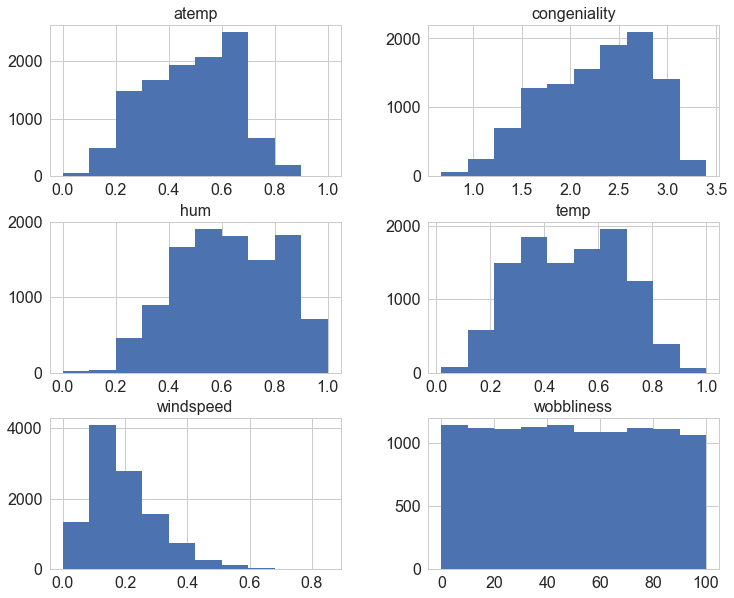

In [7]:
# the histogram indicates dteday, wobbliness, and congeniality are not normalized
X_train[num_features].hist();

#### 1.32 Categorical Features

The categorical features also look like that they are "normal".

In [8]:
# Summary statistics of categorical features
X_train[cat_features].describe()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit
count,11080.000000,11080.000000,11080.000000,11080.000000,11080.000000,11080.000000,11080.000000,10866.000000
mean,2.497112,0.499097,6.522202,11.565253,0.029693,2.978791,0.682401,1.424443
std,1.106313,0.500022,3.432725,6.932259,0.169747,2.006354,0.465564,0.641161
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000
50%,3.000000,0.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000
75%,3.000000,1.000000,9.000000,18.000000,0.000000,5.000000,1.000000,2.000000
max,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000


#### 1.33 Response Variable

However, there seems to be outliers in the response variable. Using the 1.5 * IQR rule we see there are clearly hundreds of outliers in each of the candidate response variables.

In [9]:
# Summary statistics of response variable
X_train[response].describe()

,cnt,casual,registered
count,11080.000000,11080.000000,11080.000000
mean,190.217599,35.794946,154.422653
std,182.583990,49.211941,152.823340
min,1.000000,0.000000,0.000000
25%,39.000000,4.000000,34.000000
50%,142.000000,17.000000,115.000000
75%,282.250000,49.000000,221.000000
max,976.000000,367.000000,885.000000


In [10]:
def is_outlier(value, p25, p75):
    """
    Check if value is an outlier
    """
    lower = p25 - 1.5 * (p75 - p25)
    upper = p75 + 1.5 * (p75 - p25)
    return value <= lower or value >= upper

def get_indices_of_outliers(values):
    """
    Get outlier indices (if any)
    """
    p25 = np.percentile(values, 25)
    p75 = np.percentile(values, 75)
     
    indices_of_outliers = []
    for ind, value in enumerate(values):
        if is_outlier(value, p25, p75):
            indices_of_outliers.append(ind)
    return indices_of_outliers

print "Number of sample of response variable: " + str(len(X_train[response[0]]))

for item in response:
    indices_cnt_outlier = get_indices_of_outliers(X_train[item])
    print "Number of outliers in " + str(item) + ": " + str(len(indices_cnt_outlier))

Number of sample of response variable: 11080
Number of outliers in cnt: 322
Number of outliers in casual: 749
Number of outliers in registered: 443


So far we have used univariate analysis for outlier detection, next let's use bivariate analysis to further confirm the existence of outliers.

In [11]:
def cat_boxplot(df, col, group):
    """
    df: pandas dataframe
    col: column name

    this function draws a box plot of bikeshare count
    grouped by attributes in col
    """
    sns.set(style='whitegrid', font_scale=1.4)
    f, ax = plt.subplots(figsize=(10, 8))
    sns.boxplot(x=group, y=col, data=df) 
    ax.set_title('Boxplot Grouped by ' + group)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

In the boxplot below, when we look at the distribution of "registered" user count across 24 hours. There are outliers in the hours of early morning and afternoon. Additionally, we see that during rush hours (7-9AM and 16-19PM), there are more people riding bikes.

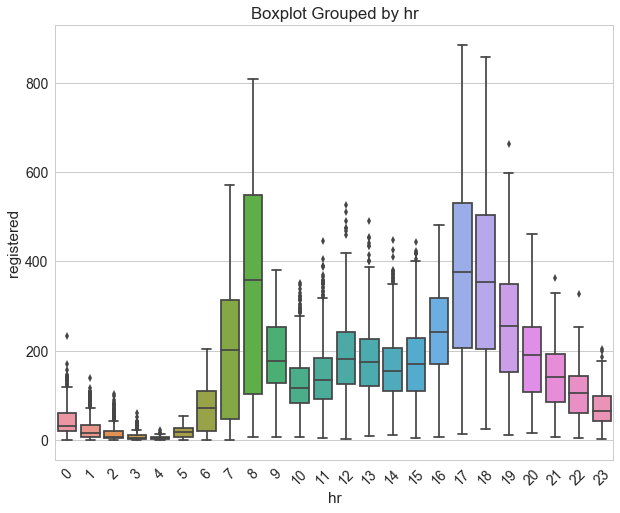

In [12]:
cat_boxplot(X_train, response[2], 'hr')

When we look at the distribution of "casual" vs "hour", we don't see as clear a trend as that of the "registered". This probabaly indicates that we should build separate for "casual" and "registered".

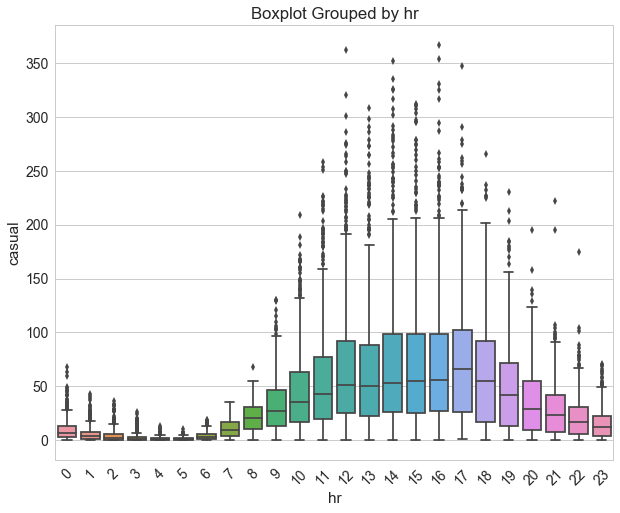

In [13]:
cat_boxplot(X_train, response[1], 'hr')

Regarding weather condition, there are outliers in the bike demand when "weathersit" = 1 (clear), 2 (mist), and 3 (light rain/snow)

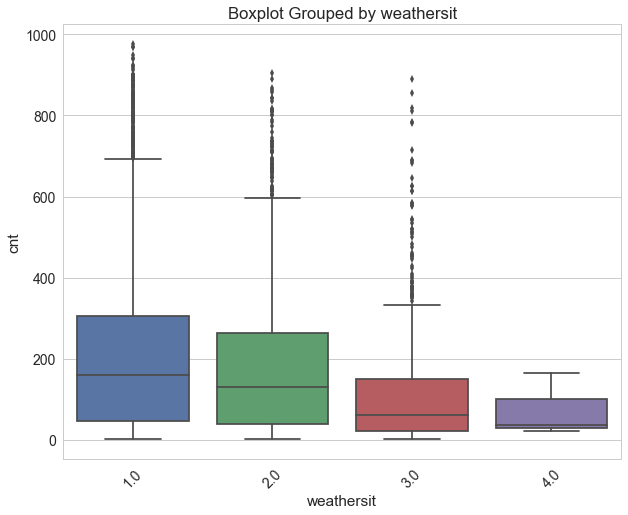

In [14]:
cat_boxplot(X_train, response[0], 'weathersit')

### 1.4 Correlation Analysis

In this section, we take a look at the correlation between candidate response variables and the rest features.

In [15]:
def corr_mat_heatmap(df):
    """
    df: pandas dataframe

    this function plots a correlation matrix heatmap based on the input dataframe
    """
    corr_matrix = df.corr()
    
    sns.set(style='white', font_scale=1.4)
    f, ax = plt.subplots(figsize=(14, 9))
    
    # Create a mask for the upper triangle
    mask = np.zeros_like(corr_matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    cmap = sns.diverging_palette(300, 50, as_cmap=True)
    sns.heatmap(corr_matrix, cmap=cmap, mask=mask, annot=True, annot_kws={'size': 12})  
    ax.set_title('Correlation Matrix Heatmap')

From the heatmap below we discover that: 
1. "temp", "atemp", and "hum" are the top 3 features correlated with candidate response variables
2. "atemp" has a 0.99 correlation with "temp" which suggest that we should only use one of them in the model
3. "congeniality" is highly correlated with "temp", "atemp", and "hum". This feature probably indicates weather-wise how comfortable a given day is
4. "wobbliness" has almost no correlation with other features and response variables. Also, we have looked at its histogram earlier on, there is no pattern of it. So it's probabaly not going to be predictive of bikeshare count.

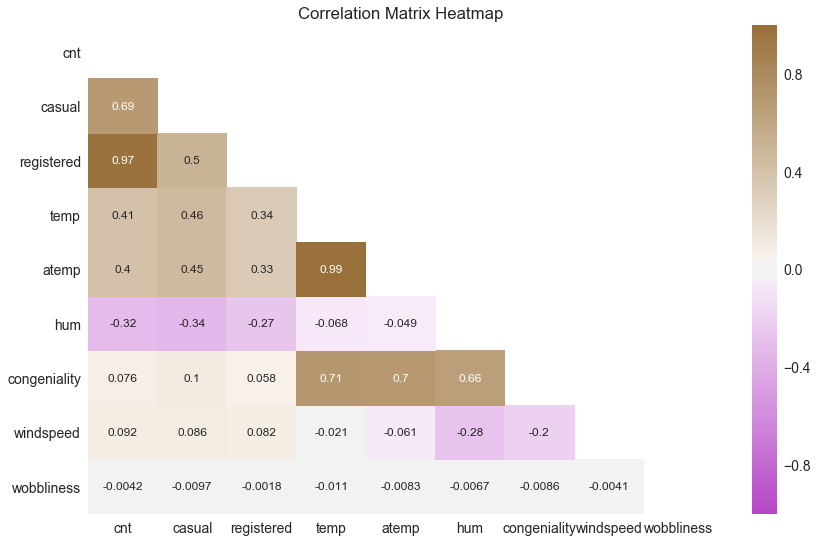

In [16]:
corr_mat_heatmap(data[response + num_features])

## 2. Feature Engineering and Modeling

In this part:
1. We will start off with some data preprocessing work
2. Then we will build our first model and analyze which features are most/least important
3. Finally we will perform some feature engineering and run our final model

Regarding the algorithms to use, we will compare the performance of linear regression, random forest, XGBoost, extra tress, and gradient boosting. Then we will select the best algorithm for the rest modeling process.

### 2.1 Data Preprocessing

#### 2.11 Missing Value Imputation

Regarding numerical features, we will impute missing values with column median. This proves to be a robust method. Other alternatives include KNN, regression imputation, and column mean. Note what we will use the training set column medians to fill the empty cells in the test set.

Regarding categorical features such as hour, holiday, and weekday, we will use "missing" to fill the missing values.

As for features to remove:
1. Since "congeniality" is highly correlated with "hum" and "atemp", therefore we will not use it. Also, "wobbliness" is removed
2. Intuitively speaking, feeling temperature is more relevant to us human than actual temperature. So I choose to use "atemp" in the model
3. "working day" and "holiday" are similary, I decided to only keep "workingday"

In [17]:
# drop features we don't need
X_train = X_train.drop(['temp', 'congeniality', 'wobbliness', 'holiday'], axis=1)
X_test = X_test.drop(['temp', 'congeniality', 'wobbliness', 'holiday'], axis=1)

In [18]:
cat_features = ['season', 'yr', 'mnth', 'hr', 'workingday', 'weekday', 'weathersit']
num_features = ['atemp', 'hum', 'windspeed']

# use Imputer from Scikit learn to impute numerical features
imputer = Imputer(strategy="median")
X_train_impute = pd.DataFrame(imputer.fit_transform(X_train[num_features]), columns=num_features)
X_train[num_features] = X_train_impute.values

X_test_impute = pd.DataFrame(imputer.transform(X_test[num_features]), columns=num_features)
X_test[num_features] = X_test_impute.values

#### 2.12 Create Dummy Variables

In [19]:
# impute categorical features and turn them into dummy variables
X_train[cat_features] = X_train[cat_features].fillna(value='missing')
X_train_prepared = pd.get_dummies(X_train, prefix_sep='_', columns=cat_features)

X_test[cat_features] = X_test[cat_features].fillna(value=0)
X_test_prepared = pd.get_dummies(X_test, prefix_sep='_', columns=cat_features)

# prepare the response variable and training/test set
y_train_casual = X_train_prepared[response[1]]
y_train_registered = X_train_prepared[response[2]]
X_train_prepared = X_train_prepared.drop(response, axis=1)

y_test_casual = X_test_prepared[response[1]]
y_test_registered = X_test_prepared[response[2]]
X_test_prepared = X_test_prepared.drop(response, axis=1)

### 2.2 Baseline Model

We will build two models, one with response variable "casual", the other with "registered". It might be luring to use "cnt" as the reponse variable. However, as we discovered in the boxplot the distribution of "casual" and "registered" across hours look quite different, which suggests separate models are needed. Also, we can alway sum up the predictions from each model to get the total count.

To evaluate the models we will use RMSE (root mean square error), it's defined as $\sqrt{(y_{response} - y_{predict})^2}$.

Alternatively, we can use MAE (mean absolute error) to evaluate a regression model. MAE is less affected by outliers, however, for the bikeshare data we do want to check if the outliers in the response variable affects our model performance, so we will stick to RMSE for the rest modeling process.

In [20]:
def train_model(data, label, algo):
    """
    data: training data
    label: response variable
    
    return: fitted model and Root Mean Square Error
    """
    model = algo.fit(data, label)
    return model


def cross_validation_rmse(model, data, label, cv=5):
    """
    data: training data
    label: response variable
    
    this function performs a 10-fold cross validation and prints out the RMSE scores
    """
    scores = cross_val_score(model, data, label, scoring="neg_mean_squared_error", cv=5)
    rmse_scores = np.sqrt(-scores)

    print('Mean of RMSE from 5-fold cross validation:', rmse_scores.mean())
    print('RMSE Standard deviation:', rmse_scores.std())
    print ''

Let's train the model and use 5-fold cross validation to compare model performance.

When "casual" is the response variable:

In [21]:
algos = [LinearRegression(), RandomForestRegressor(random_state=0),
         ExtraTreesRegressor(random_state=0), GradientBoostingRegressor(random_state=0),
         XGBRegressor()]

for algo in algos:
    model = train_model(X_train_prepared.values, y_train_casual, algo)
    cross_validation_rmse(model, X_train_prepared.values, y_train_casual)

('Mean of RMSE from 5-fold cross validation:', 31.677378294454769)
('RMSE Standard deviation:', 1.4875589849817534)

('Mean of RMSE from 5-fold cross validation:', 21.517422164585177)
('RMSE Standard deviation:', 0.98140086315711028)

('Mean of RMSE from 5-fold cross validation:', 19.75677956870382)
('RMSE Standard deviation:', 0.96754052872749474)

('Mean of RMSE from 5-fold cross validation:', 24.800802102750549)
('RMSE Standard deviation:', 0.95582655242272829)

('Mean of RMSE from 5-fold cross validation:', 24.840092695730736)
('RMSE Standard deviation:', 0.97883806700293918)



When "registered" is the response variable:

In [22]:
for algo in algos:
    model = train_model(X_train_prepared.values, y_train_registered, algo)
    cross_validation_rmse(model, X_train_prepared.values, y_train_registered)

('Mean of RMSE from 5-fold cross validation:', 86.430226667170047)
('RMSE Standard deviation:', 1.7621771380428146)

('Mean of RMSE from 5-fold cross validation:', 43.459345650025092)
('RMSE Standard deviation:', 0.84831530755078421)

('Mean of RMSE from 5-fold cross validation:', 43.420432151650417)
('RMSE Standard deviation:', 0.56634397708902262)

('Mean of RMSE from 5-fold cross validation:', 64.288976657772395)
('RMSE Standard deviation:', 1.2728683761132054)

('Mean of RMSE from 5-fold cross validation:', 64.81015207272948)
('RMSE Standard deviation:', 1.7482070450723224)



**Summary: ** we conclude that ExtraTressRegressor has the best performance whether the reponse is "casual" or "registered". The RMSE is 19.76 for "casual" and 43.42 for "registered". Therefore, we will use ExtraTressRegressor for the rest modeling process.

### 2.3 Feature Engineering

In this section, I propose three new features:
1. **hour_category**: based on the boxplot of user count vs hour, we can group hour into several categories. However, this feature doesn't improve the model performance much, so I didn't include it in the final model
2. **average_casual**: this is the average count of bike riders grouped by "month", "weekday" and "hour". This feature will be used only when "casual" is the response variable
3. **average_registered**: similar to "average_casual". This feature will be used only when "registered" is the response variable

#### 2.31 Hour Category

In [23]:
# this is how we can create the hour_category feature, since this feature doesn't 
# improve model performance much, I didn't include the result here
def hour_category(value):
    if value in range(1, 7):
        return '0-6AM'
    elif value in range(7, 9):
        return '7-8AM'
    elif value in range(9, 16):
        return '9AM-15PM'
    elif value in range(16, 20):
        return '16-19PM'
    else:
        return '20-23PM'

# X_train['hour_cat'] = X_train['hr'].apply(hour_category)
# X_test['hour_cat'] = X_test['hr'].apply(hour_category)

#### 2.32 Average Count of Casual Users and Registered Users

The "average_count" features can be useful because they reflect the average demand for a given hour at a given month/day.

In [24]:
avg_casual = pd.DataFrame(X_train.groupby(['yr', 'weekday', 'hr'])['casual'].mean()).reset_index()
avg_casual.columns = ['yr', 'weekday', 'hr', 'avg_casual']
avg_registered = pd.DataFrame(X_train.groupby(['yr', 'weekday', 'hr'])['registered'].mean()).reset_index()
avg_registered.columns = ['yr', 'weekday', 'hr', 'avg_registered']

# merge new features to the training/test set
X_train = X_train.merge(avg_casual, on=['yr', 'weekday', 'hr'])
X_train = X_train.merge(avg_registered, on=['yr', 'weekday', 'hr'])

X_test = X_test.merge(avg_casual, on=['yr', 'weekday', 'hr'])
X_test = X_test.merge(avg_registered, on=['yr', 'weekday', 'hr'])

The code below is a bit repetitive because new features are calcuated based on the original features including "month", "weekday", and "hour". We can only join the new features to the original dataset and then turn categorical features into dummy variables. Ideally, we can use Scikit-learn's Pipeline to automate the whole process, but due to time constrain I didn't do it here. 

In [25]:
# impute categorical features
X_train[cat_features] = X_train[cat_features].fillna(value='missing')
X_train_prepared = pd.get_dummies(X_train, prefix_sep='_', columns=cat_features).drop(response, axis=1)

X_test[cat_features] = X_test[cat_features].fillna(value=0)
X_test_prepared = pd.get_dummies(X_test, prefix_sep='_', columns=cat_features).drop(response, axis=1)

y_train_casual = X_train[response[1]]
y_train_registered = X_train[response[2]]

y_test_casual = X_test[response[1]]
y_test_registered = X_test[response[2]]

When there are dummy features in the training but not in the test set, append a all-zero column to account for the absent column.

In [26]:
extra_columns = set(X_train_prepared.columns).difference(set(X_test_prepared.columns))
for col in extra_columns:
    X_test_prepared[col] = 0

### 2.4 Improved Models

After feature engineering, we will build two models, one for "causal", the other for "registered"

In [27]:
X_train_casual = X_train_prepared.drop(['avg_registered'], axis=1)
X_test_casual = X_test_prepared.drop(['avg_registered'], axis=1)

X_train_registered = X_train_prepared.drop(['avg_casual'], axis=1)
X_test_registered = X_test_prepared.drop(['avg_casual'], axis=1)

Cross validation of model for "casual". The RMSE dropped from  19.76 (baseline) to 16.16.

In [28]:
extra_reg_casual = train_model(X_train_casual.values,  y_train_casual,\
                        ExtraTreesRegressor(random_state=0))
cross_validation_rmse(extra_reg_casual, \
                      X_train_casual.values, y_train_casual)

('Mean of RMSE from 5-fold cross validation:', 16.161858480046881)
('RMSE Standard deviation:', 0.62957435179530241)



Cross validation of model for "registered". The RMSE dropped from 43.42 (baseline) to 39.27.

In [29]:
extra_reg_registered = train_model(X_train_registered.values,  y_train_registered,\
                        ExtraTreesRegressor(random_state=0))
cross_validation_rmse(extra_reg_registered, \
                      X_train_registered.values, y_train_registered)

('Mean of RMSE from 5-fold cross validation:', 39.276176766651488)
('RMSE Standard deviation:', 2.1318078383682648)



### 2.5 Feature Importance Analysis

For this part, I presented the feature importance analysis when the response variable is "casual". The analysis for "registered" is similar. But we will still build two final models based on the feature importance.

In [31]:
extra_casual_importance = extra_reg_casual.feature_importances_
print "number of features in the model: " + str(len(extra_casual_importance))
importance_df = pd.DataFrame({'feature_name': X_train_casual.columns.values, 
                              'feature_importance': extra_casual_importance})

number of features in the model: 60


Regarding the feature importance the "casual" model, we can see that the new feature "avg_casual" is the most important. Next to it is "atemp", "season_1", and "hum".

In [32]:
importance_df.sort_values('feature_importance', ascending=False).head()

,feature_importance,feature_name
3,0.563741,avg_casual
0,0.144587,atemp
4,0.077877,season_1
47,0.020183,workingday_1
1,0.019056,hum


Regarding least important featues, we have "weathersit_4.0" being the least important. Indeed, the "weathersit" feature in the test set doesn't have this attribute, so we appended an all-zero column.

Next to "weathersit_4.0" is "hr_4", "hr_5", and "hr_6". Probably because the number of samples falling into these three categories is so small that these features are not predictive.

In [33]:
importance_df.sort_values('feature_importance').head()

,feature_importance,feature_name
58,1.225561e-07,weathersit_4.0
26,3.777973e-06,hr_4
27,6.118220e-06,hr_5
28,1.613322e-05,hr_6
25,1.739821e-05,hr_3


We can further visualize the feature importance score of the top 15 most important features. It seems that "season", "month", and "working day" have a impact on the bike demand.

In [34]:
def feature_importance_plot(df, top_n):
    """
    importance_list: a list of feature importance
    col_list: a list of column names matching the importance list
    
    this functions draw a plot of feature importance
    """
    important_df = df.sort_values('feature_importance', ascending=False)[:top_n]
    sns.barplot(x='feature_importance', y='feature_name', data=important_df, color="b")

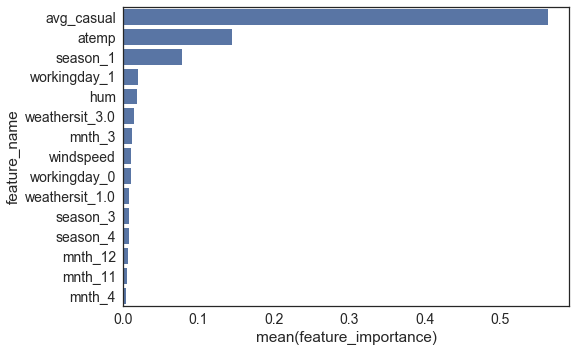

In [35]:
feature_importance_plot(importance_df, top_n=15)

### 2.6 Final Model and Prediction

Since we can extract feature importance, why not only use the top n (e.g. 50) important features to train a new model. It helps remove noisy features especially especially when we have hundreds of features. This method is more efficient than other dimension reduction algorithms, e.g. PCA.

In [36]:
def indices_of_top_k(arr, k):
    """
    this function is used with TopFeatureSelector
    """
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])


class TopFeatureSelector(BaseEstimator, TransformerMixin):
    """
    this class allows for selecting features based on feature importance
    """
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

#### 2.61 Final Model
Finally, we will use our final model to predict on the test set. Below is the model for "casual".

In [37]:
extra_casual_importance = extra_reg_casual.feature_importances_
top_casual = TopFeatureSelector(extra_casual_importance, 50)
X_train_casual_final = top_casual.fit_transform(X_train_casual.values)
extra_casual_reg = train_model(X_train_casual_final, y_train_casual, \
                        ExtraTreesRegressor(random_state=0))

print "Extra trees with most important features RMSE: "
cross_validation_rmse(extra_casual_reg, X_train_casual_final, y_train_casual)

Extra trees with most important features RMSE: 
('Mean of RMSE from 5-fold cross validation:', 15.925116277476594)
('RMSE Standard deviation:', 0.77265137087036229)



Below is the model for "registered". Note that the RMSE using only the top 50 important features is bit higher than using all features. When the performance doesn' decrease much, we can still remove some features to avoid overfitting.

In [39]:
extra_registered_feature = extra_reg_registered.feature_importances_
top_registered = TopFeatureSelector(extra_registered_feature, 50)
X_train_registered_final = top_registered.fit_transform(X_train_registered.values)
extra_registered_reg = train_model(X_train_registered_final, y_train_registered, \
                        ExtraTreesRegressor(random_state=0))

print "Extra trees with most important features RMSE: "
cross_validation_rmse(extra_registered_reg, X_train_registered_final, y_train_registered)

Extra trees with most important features RMSE: 
('Mean of RMSE from 5-fold cross validation:', 40.229267726624755)
('RMSE Standard deviation:', 2.6885664944484988)



#### 2.62 Make and Save Predictions

For "casual", the test RMSE is only 3 points higher than that of the training set. We didn't overfit the model

In [40]:
X_test_casual_final = top_casual.transform(X_test_casual.values)
y_casual_pred = extra_casual_reg.predict(X_test_casual_final)
print 'RMSE on test set is: ' + str(np.sqrt(mean_squared_error(y_test_casual, y_casual_pred)))
predict_casual_df = pd.DataFrame({'casual_real':y_test_casual, 'casual_prediction':y_casual_pred})
predict_casual_df.to_csv('bikeshare_casual_prediction.csv', index=None)
predict_casual_df.head(10)

RMSE on test set is: 18.169359392


,casual_prediction,casual_real
0,70.3,64
1,94.2,93
2,84.4,100
3,21.8,20
4,55.0,77
5,91.3,99
6,15.9,9
7,79.8,78
8,96.1,108
9,82.6,107


For "casual", the test RMSE is 52.27 - 10 points higher than that of the training set.

In [41]:
X_test_registered_final = top_registered.transform(X_test_registered.values)
y_registered_pred = extra_registered_reg.predict(X_test_registered_final)
print 'RMSE on test set is: ' + \
      str(np.sqrt(mean_squared_error(y_test_registered, y_registered_pred)))
predict_registered_df = pd.DataFrame({'registered_real':y_test_registered, \
                                      'registered_prediction':y_registered_pred})
predict_registered_df.to_csv('bikeshare_registered_prediction.csv', index=None)
predict_registered_df.head(10)

RMSE on test set is: 52.2728609516


,registered_prediction,registered_real
0,611.4,642
1,569.4,684
2,625.2,597
3,556.9,446
4,701.5,822
5,621.4,677
6,367.7,374
7,579.0,562
8,753.2,744
9,665.4,716


#### 2.63 Save Model

Finally let's save our models for future use! :)

In [42]:
joblib.dump(extra_casual_reg, "bikeshare_casual_model.pkl")
casual_model = joblib.load("bikeshare_casual_model.pkl")
casual_model

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
          oob_score=False, random_state=0, verbose=0, warm_start=False)

In [43]:
joblib.dump(extra_registered_reg, "bikeshare_registered_model.pkl")
registered_model = joblib.load("bikeshare_registered_model.pkl")
registered_model

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
          oob_score=False, random_state=0, verbose=0, warm_start=False)

## 3. Summary

For this project, we have built and improved several models to predict bike demand for the Capital Bikeshare program. The model performance for "casual" user demand is really good given the features we have. However, the model for "registered" user demand can be improved by engineering more features and including external data sources, for example bike station location. The ultimate business goal can be predicting the demand by station and hour.

Regarding the modeling process, I didn't include the hyperparameter tuning step because it can be time consuming, also the default parameter value is usually sufficient. In Scikit learn GridSearch and RandomSearch facilitate the tuning process. For documentation, please refer to: http://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection